In [1]:
import logging
from utility import add_project_root_to_path

logging.basicConfig(level=logging.ERROR)

add_project_root_to_path()

In [2]:
# Building experiments configs

from experiments.configs import DATA_SOURCE_BY_ALIAS, DEFAULT_UNINFORMED_USERS_CONFIG
from experiments.experiment import Experiment
from user.informed_user import InformedUser

from fee_algorithm.fixed_fee import FixedFee
from fee_algorithm.unequal_fee import UnequalFee
from fee_algorithm.fee_based_on_trade import FeeBasedOnTrade
from fee_algorithm.fee_based_on_historical_price import FeeBasedOnHistoricalPrice

from copy import deepcopy

fee_algos_to_consider = {
    "fixed_fee": FixedFee(exchange_fee_rate=0.003), # 30 bps
    "discrete_fee_perfect_oracle": UnequalFee(fee_rate_in_arbitrage_direction=0.0045, fee_rate_in_non_arbitrage_direction=0.0015), # 45/15 bps
    # "continuous_fee_perfect_oracle": FeeBasedOnTrade(default_fee_rate=0.003), # 30 bps
    "fee_based_on_historical_price": FeeBasedOnHistoricalPrice(decay=0.3, fee_in_increasing_deviation_direction=0.0045, fee_in_decreasing_deviation_direction=0.0015), # 45/15 bps
}

experiment_configs = {}

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    data_source = DATA_SOURCE_BY_ALIAS[period_alias]
    for fee_algo_alias, fee_algo in fee_algos_to_consider.items():
        experiment_name = f"{period_alias}_{fee_algo_alias}"
        experiment_configs[experiment_name] = Experiment(
            data=data_source,
            fee_algorithm=deepcopy(fee_algo),
            uninformed_users=deepcopy(DEFAULT_UNINFORMED_USERS_CONFIG),
            informed_user=InformedUser(),
        )

In [3]:
from pprint import pprint

pprint(experiment_configs['volatile_market_fixed_fee'])

Experiment(data=ExperimentData(start_time=datetime.datetime(2022, 11, 10, 12, 0),
                               end_time=datetime.datetime(2022, 11, 16, 12, 0),
                               A_symbol='ETH',
                               B_symbol='BTC',
                               stable_coin_symbol='USDT',
                               candle_interval='5m'),
           fee_algorithm=FixedFee(exchange_fee_rate=0.003),
           informed_user=<user.informed_user.InformedUser object at 0x1107dbe00>,
           uninformed_users=UninformedUsersConfig(uninformed_user=<user.uninformed_user.UninformedUser object at 0x127362db0>,
                                                  probability_of_trade=0.5,
                                                  n_users=1),
           total_tokens=100000)


In [4]:
pprint(experiment_configs['volatile_market_fixed_fee'])

Experiment(data=ExperimentData(start_time=datetime.datetime(2022, 11, 10, 12, 0),
                               end_time=datetime.datetime(2022, 11, 16, 12, 0),
                               A_symbol='ETH',
                               B_symbol='BTC',
                               stable_coin_symbol='USDT',
                               candle_interval='5m'),
           fee_algorithm=FixedFee(exchange_fee_rate=0.003),
           informed_user=<user.informed_user.InformedUser object at 0x1107dbe00>,
           uninformed_users=UninformedUsersConfig(uninformed_user=<user.uninformed_user.UninformedUser object at 0x127362db0>,
                                                  probability_of_trade=0.5,
                                                  n_users=1),
           total_tokens=100000)


In [5]:
from experiments.run_experiment import run_experiment
from experiments.experiment import ExperimentResult
import numpy as np

experiment_results: dict[str, ExperimentResult] = {}


for experiment_name, experiment_config in experiment_configs.items():
    np.random.seed(0)
    experiment_results[experiment_name] = run_experiment(experiment_config)

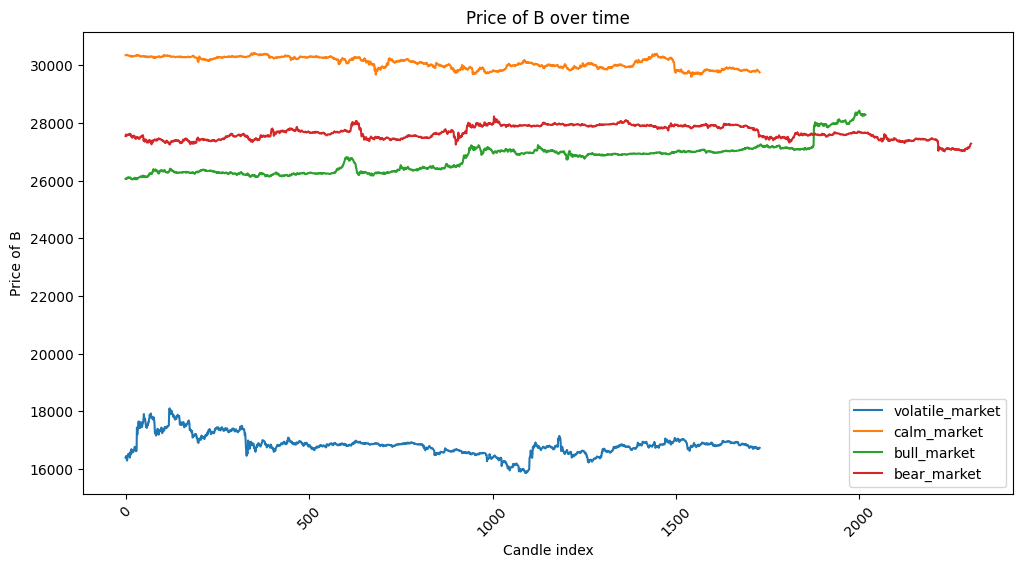

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    experiment_name = f"{period_alias}_fixed_fee"
    experiment_result = experiment_results[experiment_name]
    plt.plot(experiment_result.data["price_B"], label=period_alias)
    plt.title("Price of B over time")

plt.ylabel("Price of B")
plt.xlabel("Candle index")
# plt.yscale("log")

plt.xticks(rotation=45)

plt.legend(loc="lower right")

plt.show()

### Results

In [7]:
from visualizations.compare_fee_algoritms import plot_participants_markouts, plot_impermanent_loss, get_experiment_summary

In [8]:
def plot_results_for_period(period_alias: str, fee_algos_to_consider: list[str]):
    plot_participants_markouts(
        period_alias,
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )
    plot_impermanent_loss(
        period_alias,
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )

    summary = get_experiment_summary(
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )

    display(summary)

### Results for bull market

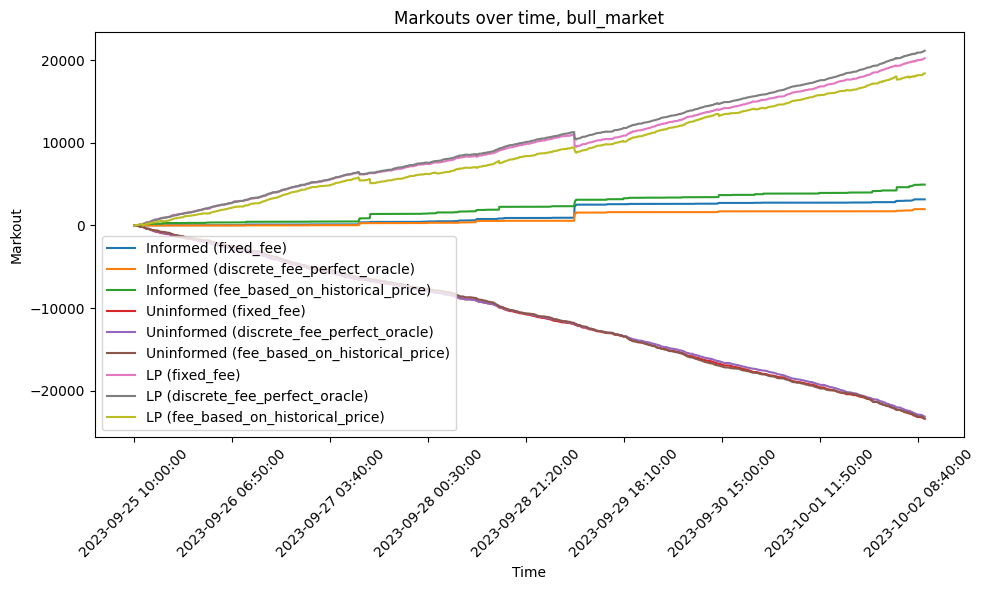

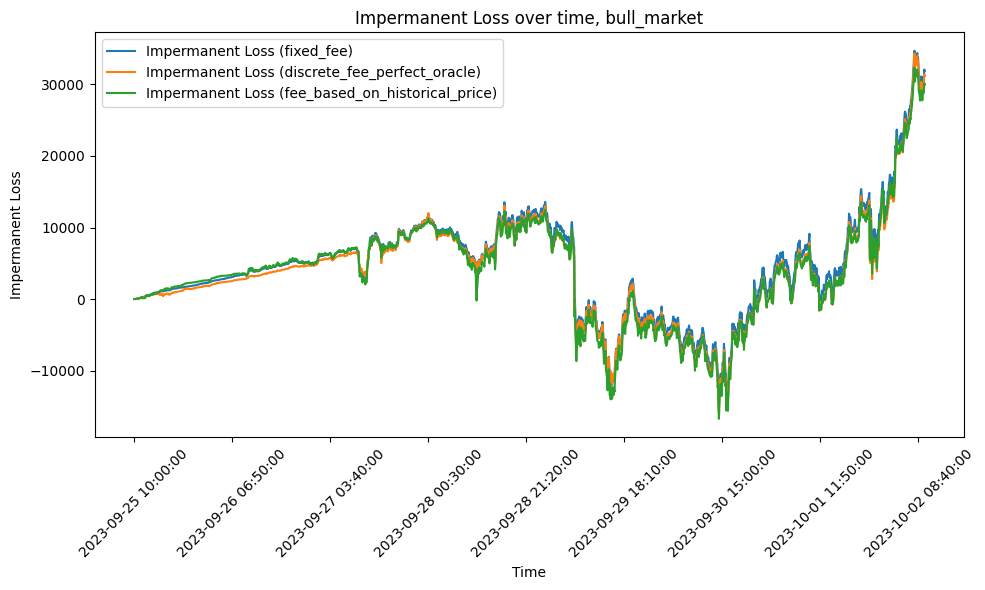

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,3165.999962,-23427.909165,20261.909203,31906.848314
1,discrete_fee_perfect_oracle,1978.116233,-23150.473922,21172.357689,31207.549859
2,fee_based_on_historical_price,4952.010193,-23392.013812,18440.003619,29995.249669


In [9]:
plot_results_for_period("bull_market", list(fee_algos_to_consider.keys()))

### Results for calm market

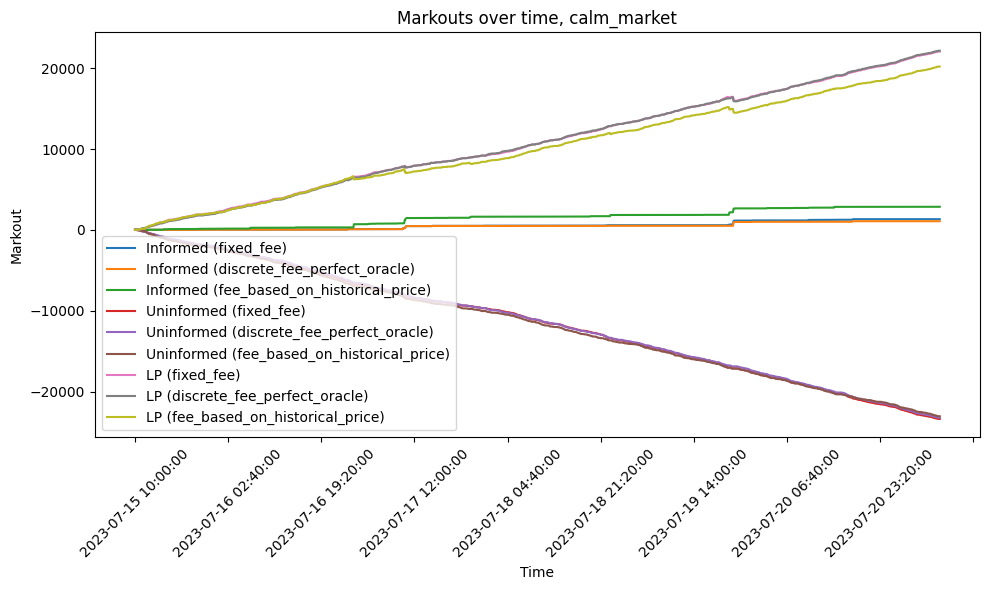

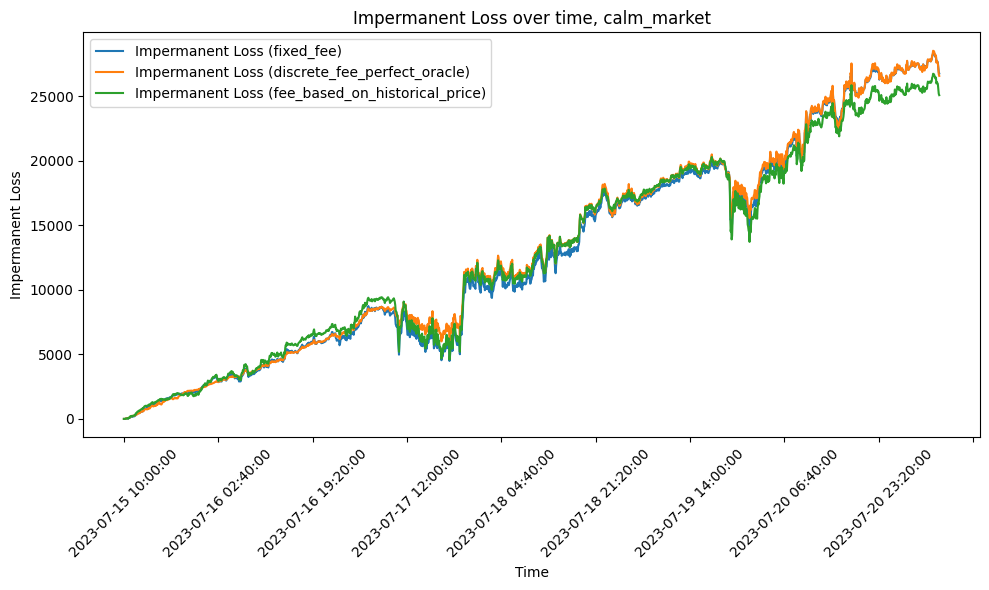

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,1318.770630,-23382.951503,22064.180873,26755.678476
1,discrete_fee_perfect_oracle,1069.493853,-23224.734900,22155.241047,26565.901262
2,fee_based_on_historical_price,2855.180702,-23051.543849,20196.363147,25071.795690


In [10]:
plot_results_for_period("calm_market", list(fee_algos_to_consider.keys()))

### Results for bear market

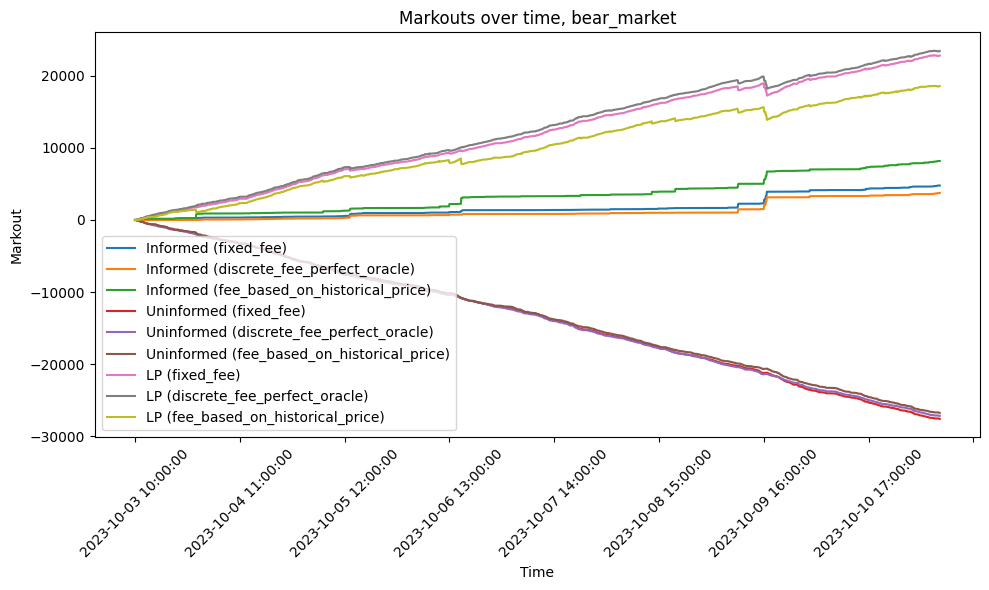

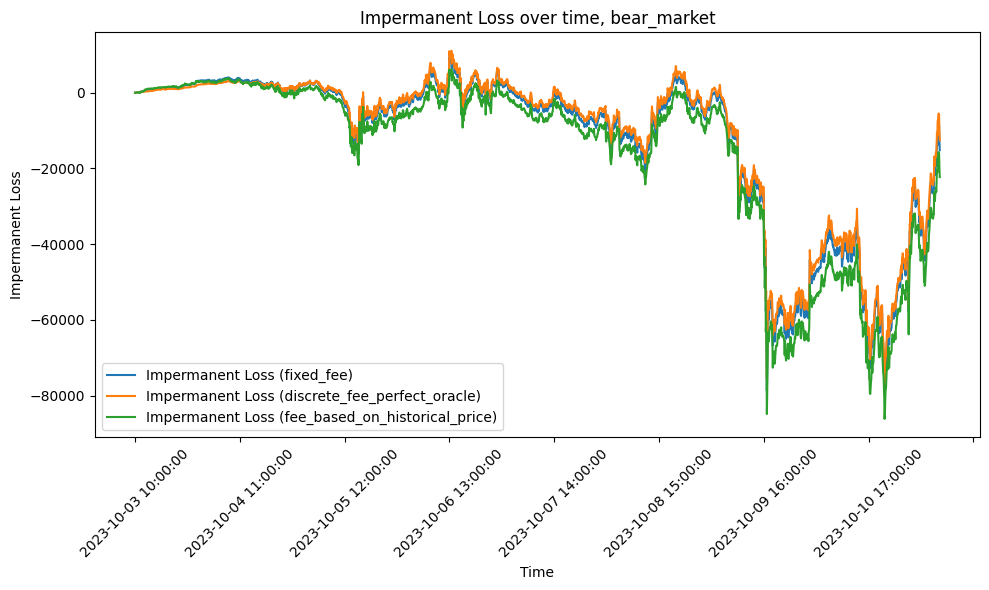

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,4782.555448,-27577.562458,22795.007009,-15196.589890
1,discrete_fee_perfect_oracle,3740.384081,-27168.671353,23428.287272,-12567.632008
2,fee_based_on_historical_price,8176.227147,-26743.952553,18567.725406,-22284.460035


In [11]:
plot_results_for_period("bear_market", list(fee_algos_to_consider.keys()))

### Results for volatile market

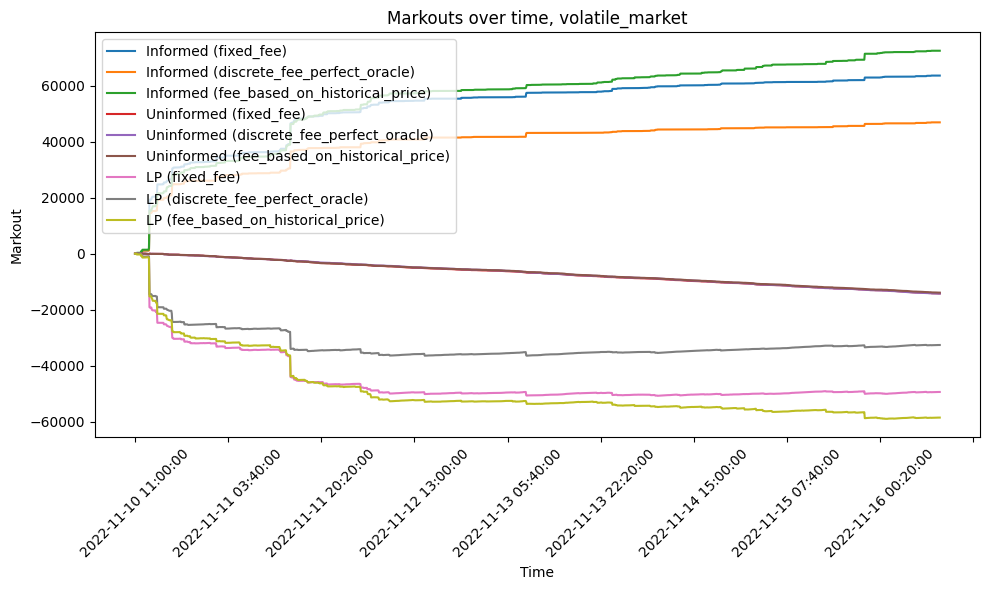

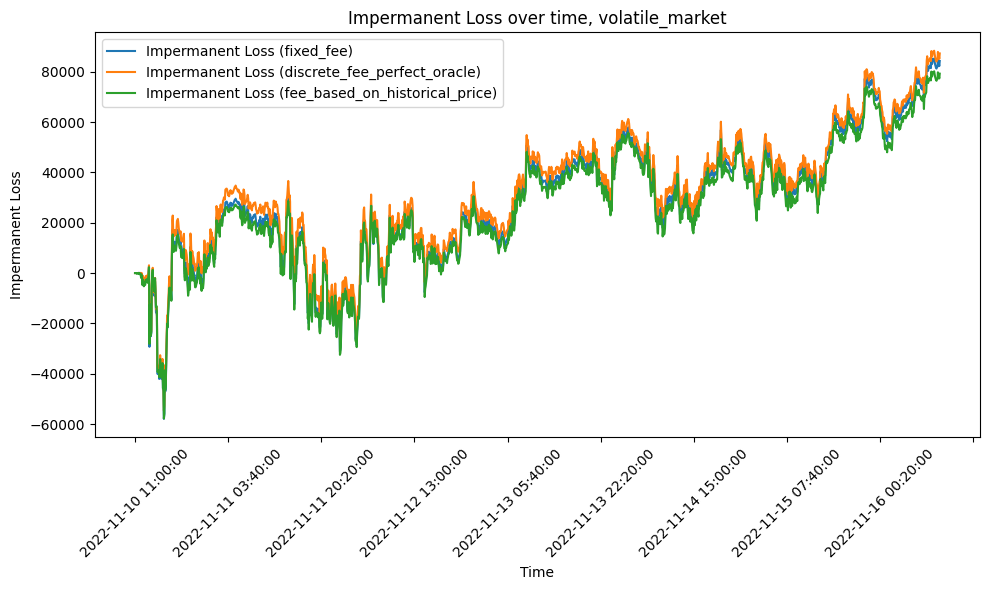

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,63541.946408,-14184.413840,-49357.532568,84262.181830
1,discrete_fee_perfect_oracle,46850.465204,-14253.232115,-32597.233090,87250.602829
2,fee_based_on_historical_price,72405.708685,-13906.730061,-58498.978624,79221.861953


In [12]:
plot_results_for_period("volatile_market", list(fee_algos_to_consider.keys()))